# Diagramming

Schema diagrams are essential tools for understanding and designing relational databases. They provide a visual representation of tables and their relationships, making complex schemas easier to comprehend at a glance.

Several diagramming notations have been used for designing relational schemas, as already introduced in the section on [Relational Theory](../20-concepts/01-relational.md). Common notations include:

* **Chen's Entity-Relationship (ER) Notation**: Uses rectangles for entities and diamonds for relationships
* **Crow's Foot Notation**: Uses symbols at line endpoints to indicate cardinality (one, many, optional)
* **UML Class Diagrams**: Adapted from object-oriented modeling

DataJoint uses its own diagramming notation that is specifically designed for working with directed acyclic graphs (DAGs) and makes relationship types immediately visible through line styles.

## Comparison to Other Diagramming Notations

DataJoint's diagramming approach differs significantly from traditional database diagramming notations. Understanding these differences helps you appreciate the design philosophy behind DataJoint and how to read diagrams effectively.

### Chen's Entity-Relationship (ER) Notation

**Chen's notation**, developed by Peter Chen in 1976, makes a strict distinction between:
- **Entities** (rectangles): Things that exist independently (e.g., Customer, Product)
- **Relationships** (diamonds): Associations between entities (e.g., "purchases", "owns")
- **Attributes** (ovals): Properties of entities

**Example**: A many-to-many relationship between `Customer` and `Product` would be drawn as:
```
[Customer] ──── <purchases> ──── [Product]
    1              M:N              1
```

**Key Differences from DataJoint**:
- DataJoint **does not distinguish** between entity tables and relationship tables—both are just tables
- In DataJoint, association tables (like `CustomerProduct`) appear as regular tables with converging foreign keys
- **Why DataJoint differs**: The boundary between entities and relationships is often blurred. For example, a synapse between neurons could be viewed as either an entity (with properties like strength, neurotransmitter type) or as a relationship (connecting two neurons). DataJoint treats everything uniformly as tables.

### Crow's Foot Notation

**Crow's Foot notation** (also called Information Engineering notation) uses symbols at line endpoints to indicate cardinality:

```
Customer ||────o{ Order
         ||────o{ indicates "one to zero-or-many"
         
Symbols:
|| = exactly one
|o = zero or one  
}o = zero or many
}| = one or many
```

**Key Differences from DataJoint**:
- **Endpoint symbols vs. line styles**: Crow's Foot puts cardinality information at line endpoints; DataJoint uses line thickness and style (thick/thin/dashed)
- **No directionality**: Crow's Foot diagrams don't inherently have a top-to-bottom flow; DataJoint diagrams always show dependencies flowing downward
- **Nullable indication**: Crow's Foot explicitly shows optional relationships with the 'o' symbol; DataJoint doesn't show nullable foreign keys in the diagram
- **Primary key cascade**: Crow's Foot doesn't distinguish between foreign keys in primary keys vs. secondary attributes; this is DataJoint's most important visual feature

### UML Class Diagrams

**UML (Unified Modeling Language)** was designed for object-oriented programming but is sometimes adapted for database design:

```
┌─────────────┐         ┌─────────────┐
│  Customer   │1       *│   Order     │
│─────────────│◆────────│─────────────│
│ customerId  │         │ orderId     │
│ name        │         │ orderDate   │
└─────────────┘         └─────────────┘
```

**Key Differences from DataJoint**:
- **Composition vs. aggregation**: UML uses filled vs. hollow diamonds to show ownership strength; DataJoint uses solid vs. dashed lines
- **Object-oriented focus**: UML emphasizes inheritance and methods; DataJoint focuses purely on data relationships
- **Multiplicity notation**: UML uses `1`, `*`, `0..1` at line ends; DataJoint uses line styles

### DataJoint's Unique Features

What makes DataJoint diagrams distinctive:

1. **Directed Acyclic Graph (DAG) Requirement**
   - **No cycles allowed**: Foreign keys cannot form loops
   - **Automatic layout**: All dependencies point in one direction (top-to-bottom)
   - **Workflow interpretation**: Diagrams naturally represent operational sequences
   - Other notations allow cycles (e.g., Employee → Department → Manager → Employee)

2. **Line Style Encodes Semantic Information**
   - **Thick solid**: Extension/specialization (one-to-one, shared identity)
   - **Thin solid**: Containment/belonging (one-to-many, cascading identity)
   - **Dashed**: Reference/association (one-to-many, independent identity)
   - Other notations use line endpoints or labels, not line style itself

3. **Primary Key Cascade Visibility**
   - **Solid lines** (thick or thin) mean parent's primary key becomes part of child's identity
   - This is critical for understanding which tables can be joined directly
   - No other notation makes this distinction visible

4. **No Distinction Between Entities and Relationships**
   - Association tables look like any other table
   - Reflects reality: relationships often have attributes and can participate in other relationships
   - Example: A `Synapse` table connecting neurons could be an entity (with properties) or a relationship

5. **Underlined Names for Independent Entities**
   - **Underlined**: Table has its own independent primary key (a "dimension")
   - **Not underlined**: Table's primary key is inherited from parent (an "extension")
   - Helps identify which tables are starting points vs. elaborations

### Comparison Table

| Feature | Chen's ER | Crow's Foot | UML | DataJoint |
|---------|-----------|-------------|-----|-----------|
| **Entities vs. Relationships** | Distinct (rect vs. diamond) | No distinction | Classes vs. associations | No distinction |
| **Cardinality Display** | Numbers near entities | Symbols at line ends | Multiplicity at ends | Line thickness/style |
| **Direction** | No inherent direction | No inherent direction | Optional arrows | Always directed (DAG) |
| **Cycles Allowed** | Yes | Yes | Yes | **No** (acyclic only) |
| **Primary Key Cascade** | Not shown | Not shown | Not emphasized | **Solid lines show this** |
| **Optional Relationships** | Shown in labels | 'o' symbol | `0..1` notation | Not visible in diagram |
| **Identity Sharing** | Not indicated | Not indicated | Composition diamond | **Thick solid line** |
| **Containment** | Not distinguished | Not distinguished | Aggregation diamond | **Thin solid line** |

### Why DataJoint's Approach Matters

The DAG constraint and line style notation are not just aesthetic choices—they reflect a **design philosophy**:

1. **Schemas as Workflows**: Because there are no cycles, you can read any DataJoint schema as a sequence of operations or transformations. Start at the top (independent entities) and work your way down (derived results).

2. **Query Simplicity**: Solid lines tell you which tables can be joined directly. If you can trace a path of solid lines between two tables, you can join them without including intermediate tables.

3. **Identity Semantics**: The line style immediately tells you whether entities share identity (thick), have contextualized identity (thin), or maintain independent identity (dashed).

4. **Avoiding Self-References**: The no-cycles rule means you never have a table with a foreign key to itself. Instead, you create association tables (like `ReportsTo` connecting employees to managers), which makes relationships explicit and queryable.

### Working with Non-DataJoint Schemas

When you encounter schemas designed in other notations:

- **Look for cycles**: If present, you'll need to break them into association tables for DataJoint
- **Identify many-to-many relationships**: These always need association tables in DataJoint (and in actual SQL)
- **Check foreign key placement**: Determine whether they should be in primary keys (solid lines) or secondary attributes (dashed lines)
- **Use `spawn_missing_classes()`**: DataJoint can automatically generate Python classes from existing MySQL/MariaDB databases

Consider the following diagram of the classic sales database, which is a popular example of a relational database schema from the [MySQL tutorial](https://www.mysqltutorial.org/getting-started-with-mysql/mysql-sample-database/), reproduced here for convenience:

```{image} ../images/mysql-classic-sales-ERD.png
---
:alt: Sales Database ERD
:width: 600px
---
```

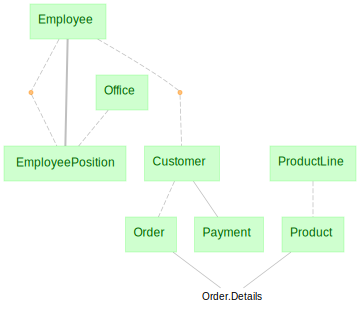

In [ ]:
import datajoint as dj

schema = dj.Schema("classic_sales")
schema.spawn_missing_classes()

dj.Diagram(schema)


### Comparing the Two Representations

The MySQL tutorial ERD (above) and the DataJoint diagram (above) represent the same database, but there are significant visual and conceptual differences:

#### 1. Direction and Layout

**Crow's Foot (MySQL ERD)**:
- No inherent direction—tables are arranged for visual balance
- Relationships flow in all directions (left, right, up, down)
- Must read cardinality symbols at both ends of each line to understand relationships

**DataJoint Diagram**:
- Strict top-to-bottom flow (directed acyclic graph)
- Dependencies always point downward (parent above, child below)
- Can read the schema as a workflow from top to bottom
- **Insight**: The vertical position tells you dependency order—tables at the top can be populated first

#### 2. Cardinality Indication

**Crow's Foot Notation**:
- Uses symbols at line endpoints: `||` (one), `o` (zero/optional), `{` (many)
- Example: `||────o{` means "one to zero-or-many"
- Shows both sides of the relationship explicitly
- **Advantage**: Makes optional relationships (nullable foreign keys) visible

**DataJoint Notation**:
- Uses line thickness and style: thick solid, thin solid, dashed
- Line style indicates whether foreign key is in primary key or not
- Does **not** show nullable foreign keys (must check table definition)
- **Advantage**: Line style conveys semantic meaning (extension vs. containment vs. reference)

#### 3. Entity vs. Relationship Distinction

**Crow's Foot / Chen's ER**:
- In Chen's notation, relationships are drawn as diamonds
- Crow's Foot treats all tables uniformly but conceptually distinguishes entities from relationships
- Many-to-many relationships are often shown with special notation

**DataJoint**:
- **No distinction** between entity tables and association tables—all are tables
- Association tables (like `CustomerAccount`) look identical to entity tables
- Recognize associations by their converging foreign key pattern
- **Philosophy**: "A synapse between neurons is both an entity (with properties) and a relationship (connecting neurons)—why force a distinction?"

#### 4. Primary Key Propagation

**Crow's Foot**:
- Does not visually distinguish between foreign keys in primary keys vs. secondary attributes
- Cannot tell from the diagram whether you can join tables directly or need intermediate tables

**DataJoint**:
- **Solid lines** (thick or thin) mean foreign key is in primary key → primary key cascades
- **Dashed lines** mean foreign key is secondary → no cascade
- **Critical advantage**: You can see at a glance which tables can be joined directly
- Example: If `A → B → C` are connected by solid lines, then `A * C` is a valid join

#### 5. Handling Cycles

**Traditional Notations**:
- Allow cyclic relationships (e.g., Employee → Department → Manager → Employee)
- Self-referencing tables are common (Employee table with manager_id field)

**DataJoint**:
- **No cycles allowed**—all schemas must be directed acyclic graphs (DAGs)
- Self-referencing tables are avoided
- Instead, use association tables: `Employee` → `ReportsTo` → `Employee` (renamed)
- **Benefit**: Schemas can always be laid out top-to-bottom as workflows

#### 6. Table Independence (Dimensions)

**Traditional Notations**:
- Don't visually distinguish between independent entities and dependent entities

**DataJoint**:
- **Underlined table names**: Independent entities (dimensions) with their own primary key
- **Non-underlined names**: Dependent entities whose primary key is inherited from parent
- Helps identify which tables are "starting points" vs. "elaborations"

### Visual Comparison Example

Consider a simple scenario: Customers placing Orders containing Items.

**Crow's Foot would show**:
```
Customer ||────o{ Order o{────|| OrderItem }o────|| Product
   1              M         M              M           1
```

**DataJoint shows**:

```
Customer        Product
    │              │
    │ (dashed)     │ (dashed)
    ↓              ↓
  Order    ───────┘
    │ (thin solid)
    ↓
OrderItem
```

**Reading the DataJoint diagram**:
- Dashed lines to `Order`: Customer and Product references are secondary (Order has its own ID)
- Thin solid line to `OrderItem`: Items belong to orders, identified as (order_id, item_number)
- All solid lines point down: Top-to-bottom workflow (create customers/products, then orders, then items)

### Advantages of Each Notation

**Chen's ER Notation**:
- ✅ Clear conceptual modeling (entities vs. relationships explicit)
- ✅ Good for initial design discussions with non-technical stakeholders
- ❌ Awkward for implementation (relationship diamonds don't map directly to tables)

**Crow's Foot Notation**:
- ✅ Shows nullable relationships clearly
- ✅ Explicit cardinality on both sides
- ✅ Widely recognized in industry
- ❌ No directionality makes complex schemas harder to read
- ❌ Doesn't show primary key cascade

**DataJoint Notation**:
- ✅ Line style conveys semantic meaning (extension, containment, reference)
- ✅ Solid lines reveal which tables can be joined directly
- ✅ DAG structure makes schemas readable as workflows
- ✅ Underlined names identify independent entities
- ❌ Nullable foreign keys not visible
- ❌ Secondary unique constraints not visible
- ❌ Less familiar to those trained in traditional notations

### Best Practices: When to Use Each

- **Use Chen's ER** for: Initial conceptual modeling with stakeholders
- **Use Crow's Foot** for: Documentation of existing databases, focusing on cardinality
- **Use DataJoint** for: Scientific workflows, hierarchical data, when query patterns matter
- **Use UML** for: Object-relational mapping in application development

### Converting Between Notations

When converting from Crow's Foot or ER diagrams to DataJoint:

1. **Identify independent entities** → These become top-level tables (underlined)
2. **Find many-to-many relationships** → Create association tables with both foreign keys in primary key
3. **Determine foreign key placement**:
   - Does child belong to parent? → Foreign key in primary key (solid line)
   - Does child reference parent? → Foreign key in secondary attributes (dashed line)
4. **Break any cycles** → Create association tables to maintain acyclic property
5. **Check for self-references** → Replace with association tables using renamed foreign keys

### Side-by-Side Notation Comparison

Let's see how the same simple schema (Authors writing Books) would be represented in each notation:

#### The Schema Requirements:
- Authors are identified by author_id
- Books are identified by ISBN
- One book can have multiple authors (many-to-many relationship)
- Authors can write multiple books

#### Chen's Entity-Relationship Notation

```
┌─────────┐              ┌──────────┐              ┌─────────┐
│ AUTHOR  │              │  writes  │              │  BOOK   │
├─────────┤              │          │              ├─────────┤
│author_id│──────M───────│    M:N   │──────N───────│  ISBN   │
│  name   │              │          │              │  title  │
└─────────┘              └──────────┘              └─────────┘
  (entity)              (relationship)                (entity)
```

**Features**:
- Rectangles for entities, diamond for relationship
- M:N explicitly labeled in the relationship diamond
- Relationship "writes" is a named concept
- Three visual elements for what SQL implements as three tables

#### Crow's Foot Notation

```
┌─────────────┐                           ┌─────────────┐
│   Author    │                           │    Book     │
├─────────────┤                           ├─────────────┤
│ author_id PK│o{────────writes────────}o│  ISBN    PK │
│ name        │                           │  title      │
└─────────────┘                           └─────────────┘
         │                                      │
         └───────o{    AuthorBook    {o────────┘
                 ├─────────────────┤
                 │ author_id PK,FK │
                 │ ISBN PK,FK      │
                 │ order           │
                 └─────────────────┘
```

**Features**:
- `o{` symbols show "zero or many" at line endpoints
- PK and FK labels on attributes
- Association table explicitly shown
- No inherent top-to-bottom flow

#### DataJoint Notation (What You Saw Above)

```
   Author              Book
     │                  │
     │ (thin solid)     │ (thin solid)
     ↓                  ↓
        AuthorBook
```

In code:
```python
@schema
class Author(dj.Manual):
    definition = """
    author_id : int
    ---
    name : varchar(100)
    """

@schema
class Book(dj.Manual):
    definition = """
    isbn : varchar(13)
    ---
    title : varchar(200)
    """

@schema
class AuthorBook(dj.Manual):
    definition = """
    -> Author
    -> Book
    ---
    author_order : tinyint
    """
```

**Features**:
- No special notation for association table—looks like any other table
- Thin solid lines indicate foreign keys are in primary key (cascading identity)
- Top-to-bottom layout shows you can populate Author and Book first, then AuthorBook
- Underlined names show Author and Book are independent dimensions

### Key Observations

1. **Cyclic vs. Acyclic**:
   - Traditional notations allow: `Employee ←→ Department ←→ Manager ←→ Employee` (cycle)
   - DataJoint requires: `Employee` → `Department` → `DepartmentManager` (acyclic)

2. **Information Density**:
   - Crow's Foot shows more detail (nullable, optional)
   - DataJoint emphasizes structure and flow
   - Both require hovering/inspection for complete details

3. **Semantic Meaning**:
   - Traditional: Focus on cardinality (how many)
   - DataJoint: Focus on identity cascade (how entities relate conceptually)

4. **Reading Strategy**:
   - Crow's Foot: Examine each endpoint's symbols
   - DataJoint: Follow the line styles and direction

### When Each Notation Excels

**Use Chen's ER when**:
- Doing initial conceptual modeling
- Working with business stakeholders
- Need to explicitly name relationships
- Database implementation is secondary

**Use Crow's Foot when**:
- Documenting existing databases
- Cardinality and optionality are critical
- Working with DBAs familiar with this standard
- Need to show all relationship details

**Use DataJoint when**:
- Designing scientific workflows
- Primary key cascade matters for your queries
- Working with hierarchical or time-series data
- The DAG structure matches your domain (no cycles)
- You want diagrams to be executable (code generates diagrams)

## Conceptual Design vs. Implementation: A Key Philosophical Difference

Database design is traditionally taught as a **two-phase process**:

1. **Conceptual Design Phase**: Create ER diagrams to model entities and relationships
2. **Implementation Phase**: Translate the conceptual model into SQL CREATE TABLE statements

This separation reflects a workflow where design and implementation are distinct activities, often performed by different people or at different times.

### Traditional Two-Phase Approach

In most database textbooks and courses, the process looks like this:

```
Step 1: Conceptual Design
├─ Use Chen's ER diagrams or Crow's Foot notation
├─ Focus on entities, relationships, cardinalities
├─ Design without worrying about implementation details
└─ Create diagrams for discussion and approval

           ↓ (Manual Translation)

Step 2: Implementation
├─ Write SQL CREATE TABLE statements
├─ Define primary keys and foreign keys
├─ Implement constraints and indexes
└─ Hope the implementation matches the design!

           ↓ (Potential Divergence)

Problem: Diagrams and Implementation Can Drift Apart
├─ Diagrams updated → SQL not updated (documentation out of sync)
├─ SQL updated → Diagrams not updated (design drift)
└─ Requires discipline to keep them synchronized
```

**Characteristics**:
- **Two separate artifacts**: Diagram (conceptual) and SQL code (implementation)
- **Manual synchronization**: Changes must be made in both places
- **Documentation debt**: Over time, diagrams often become outdated
- **Waterfall-oriented**: Design must be "complete" before implementation
- **Communication gap**: Designers and implementers may be different people

### DataJoint's Unified Approach

DataJoint fundamentally changes this by **merging conceptual design and implementation**:

```
Single Step: Unified Design-Implementation
├─ Write Python class definitions (or SQL if preferred)
├─ DataJoint automatically creates tables in database
├─ DataJoint automatically generates diagrams from live schema
└─ Diagram and implementation are ALWAYS in sync

           ↓ (No Translation Needed)

Result: Diagrams ARE the Implementation
├─ Change the code → Diagram updates automatically
├─ Diagram always reflects actual database structure
└─ Zero documentation debt
```

**Characteristics**:
- **Single source of truth**: The code IS the design
- **Automatic synchronization**: Diagrams generated from actual database schema
- **Always current**: Diagrams cannot become outdated
- **Agile-friendly**: Can iterate on design rapidly
- **Executable documentation**: Diagrams are generated from running code

### Practical Implications

#### Traditional Approach Example:

**Phase 1 - Conceptual Design** (ER Diagram):
```
[Student] ──enrolls in─── [Course]
   1                M:N        1
```

**Phase 2 - Implementation** (Manual SQL):
```sql
CREATE TABLE student (
    student_id INT PRIMARY KEY,
    name VARCHAR(100)
);

CREATE TABLE course (
    course_id INT PRIMARY KEY,
    title VARCHAR(100)
);

CREATE TABLE enrollment (
    student_id INT,
    course_id INT,
    PRIMARY KEY (student_id, course_id),
    FOREIGN KEY (student_id) REFERENCES student(student_id),
    FOREIGN KEY (course_id) REFERENCES course(course_id)
);
```

**Problem**: If you later add a `grade` field to enrollment, you must:
1. Update the SQL code
2. Update the ER diagram manually
3. Update all documentation
4. Risk: Steps 2-3 often get skipped

#### DataJoint Unified Approach:

**Single Definition** (Code + Diagram in one):
```python
@schema
class Student(dj.Manual):
    definition = """
    student_id : int
    ---
    name : varchar(100)
    """

@schema
class Course(dj.Manual):
    definition = """
    course_id : int
    ---
    title : varchar(100)
    """

@schema
class Enrollment(dj.Manual):
    definition = """
    -> Student
    -> Course
    ---
    grade : char(1)  # Added later
    """

# Diagram is automatically generated
dj.Diagram(schema)
```

**Advantage**: 
- Add `grade` field → Save file → Diagram updates automatically
- **Impossible** for diagram to be out of sync with implementation
- Code review catches design changes (they're in the same artifact)

### Enabling Agile Database Design

This unified approach enables an **agile, iterative workflow**:

**Traditional Approach** (Waterfall):
```
Design → Review → Approve → Implement → Test → Deploy
  ↑                                                |
  └────────────── Difficult to go back ───────────┘
```

**DataJoint Approach** (Agile):
```
Design+Implement → Test → Iterate → Deploy
       ↓                      ↑
       └──── Easy iteration ──┘
```

Benefits:
1. **Rapid prototyping**: Define a table, see the diagram immediately
2. **Safe experimentation**: Change foreign keys, instantly see impact on diagram
3. **Continuous refinement**: Iterate on design as you learn more about your domain
4. **Team collaboration**: Everyone works with the same code that generates diagrams
5. **Version control**: Git tracks both design and implementation (they're the same file)

### The Bi-Directional Property

DataJoint's approach is **bi-directional**:

**Code → Diagram** (Normal workflow):
```python
# Write Python class definition
@schema
class MyTable(dj.Manual):
    definition = "..."

# Generate diagram
dj.Diagram(schema)  # Automatically reflects code
```

**Database → Code → Diagram** (Reverse engineering):
```python
# Connect to existing database
schema = dj.Schema('existing_db')

# Spawn Python classes from tables
schema.spawn_missing_classes()

# Generate diagram
dj.Diagram(schema)  # Reflects actual database structure
```

This means you can:
- Import existing databases and immediately visualize them
- Start from either code or database and get the diagram
- Ensure documentation always matches reality

### Comparison Summary

| Aspect | Traditional Two-Phase | DataJoint Unified |
|--------|----------------------|-------------------|
| **Design artifact** | ER/Crow's Foot diagram | Python/SQL code |
| **Implementation artifact** | SQL statements | Same as design |
| **Diagram generation** | Manual (tools like Visio) | Automatic from code |
| **Synchronization** | Manual discipline | Automatic |
| **Change process** | Update both separately | Update code once |
| **Version control** | Separate files | Single source |
| **Agility** | Waterfall-oriented | Iteration-friendly |
| **Documentation debt** | Accumulates over time | Impossible to accrue |
| **Learning curve** | Learn notation, then SQL | Learn one syntax |

### Implications for This Chapter

Because DataJoint diagrams are automatically generated from implementation, this chapter teaches you:

1. **How to read** what the diagram tells you about the actual database
2. **How to design** by choosing appropriate line styles (which determines implementation)
3. **How to think** about the semantic meaning of relationships (not just cardinality)

When you learn to read DataJoint diagrams, you're simultaneously learning:
- How the database is structured (implementation)
- How entities relate to each other (conceptual model)
- How to query the data (query patterns follow diagram structure)

**The bottom line**: In DataJoint, the diagram is not a separate design document—it's a **live view** of your implemented schema. This makes diagrams more trustworthy, more useful, and more integral to the development process.

## DataJoint Diagram Structure

A DataJoint schema is depicted as a **Directed Acyclic Graph (DAG)**, where:

* **Nodes** represent tables in the database
* **Edges** represent foreign key constraints between tables
* **Direction** always flows from parent (referenced) to child (referencing) tables

The key constraint in DataJoint is that **foreign keys cannot form cycles** - you cannot have a chain of foreign keys that loops back to a starting table. This constraint ensures that:

1. Schemas can always be visualized as top-to-bottom workflows
2. Data dependencies are clear and unambiguous
3. Queries can follow predictable patterns

Tables at the top of the diagram are independent entities (no foreign keys to other tables), while tables lower in the diagram depend on tables above them.

## Foreign Keys Always Reference Primary Keys

DataJoint enforces a simplifying convention that distinguishes it from raw SQL and other database frameworks: **foreign keys always reference the primary key of the parent table**.

### SQL's Flexibility vs. DataJoint's Constraint

**In SQL**, foreign keys can reference any unique key (not just the primary key):

```sql
-- SQL allows this:
CREATE TABLE employee (
    employee_id INT PRIMARY KEY,
    ssn VARCHAR(11) UNIQUE,
    name VARCHAR(100)
);

CREATE TABLE access_log (
    log_id INT PRIMARY KEY,
    employee_ssn VARCHAR(11),  -- References SSN, not employee_id!
    timestamp DATETIME,
    FOREIGN KEY (employee_ssn) REFERENCES employee(ssn)
);
```

**In DataJoint**, this is not allowed:

```python
# DataJoint only allows references to primary keys
@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int
    ---
    ssn : varchar(11)
    unique index(ssn)
    name : varchar(100)
    """

@schema
class AccessLog(dj.Manual):
    definition = """
    log_id : int
    ---
    -> Employee  # MUST reference employee_id (the primary key), not ssn
    timestamp : datetime
    """
```

### Why This Constraint?

This restriction provides several benefits:

1. **Simplicity**: No ambiguity about what foreign keys reference
2. **Consistency**: All relationships work the same way
3. **Diagrammatic clarity**: Every edge in the diagram represents a primary key reference
4. **Identity-based relationships**: Relationships are between entities (identified by primary keys), not between arbitrary attributes
5. **Query optimization**: Primary keys always have indexes; other unique keys may not

**Design principle**: If you need to reference a secondary unique key, that often indicates the entity should be redesigned with that key as the primary key, or the relationship should go through a different table.

### Renamed Foreign Keys: When Names Don't Match

Most of the time, foreign key attributes have the **same names** as the primary key attributes they reference:

```python
@schema
class Customer(dj.Manual):
    definition = """
    customer_id : int    # Primary key
    ---
    name : varchar(100)
    """

@schema
class Order(dj.Manual):
    definition = """
    order_id : int
    ---
    -> Customer          # Creates foreign key: customer_id → customer_id
    order_date : date
    """
```

In `Order`, the foreign key attribute is automatically named `customer_id` (same as in `Customer`).

However, sometimes you need **different names**. Common scenarios:

1. **Multiple references to the same table** (e.g., presynaptic and postsynaptic neurons)
2. **Semantic clarity** (e.g., `manager_id` instead of `employee_id` for a manager reference)
3. **Avoiding name conflicts** (when two parents have identically named primary keys)

### Renamed Foreign Keys Using `.proj()`

DataJoint uses **projection** to rename foreign key attributes:

```python
@schema
class Neuron(dj.Manual):
    definition = """
    neuron_id : int
    ---
    neuron_type : varchar(20)
    """

@schema
class Synapse(dj.Manual):
    definition = """
    synapse_id : int
    ---
    -> Neuron.proj(presynaptic='neuron_id')   # Renames to 'presynaptic'
    -> Neuron.proj(postsynaptic='neuron_id')  # Renames to 'postsynaptic'
    strength : float
    """
```

**What happens**:
- Instead of creating `neuron_id`, creates `presynaptic` and `postsynaptic`
- Both still reference the `neuron_id` primary key in the `Neuron` table
- Allows two foreign keys from the same child to the same parent

### Orange Dots in Diagrams: Visualizing Renamed References

When foreign keys are renamed, DataJoint diagrams show them as **orange dots** (intermediate nodes):

```
        Neuron
         /         /       (●)     (●)  ← Orange dots represent renamed references
     |       |
     ↓       ↓
      Synapse
```

The orange dots indicate:
- A **projection** has been applied to rename the foreign key
- The actual foreign key attribute name differs from the parent's primary key name
- Multiple edges can connect the same pair of tables

**In the actual diagram**, hovering over the orange dot reveals:
- The parent table being referenced (`Neuron`)
- The projection expression (e.g., `presynaptic='neuron_id'`)
- The renamed attribute name

### Multiple Edges Between Tables

This naming mechanism enables **multigraphs**—where two tables can be connected by multiple distinct foreign keys:

#### Example 1: Neural Connectivity

```python
@schema
class Neuron(dj.Manual):
    definition = """
    neuron_id : int
    ---
    layer : int
    neuron_type : enum('excitatory', 'inhibitory')
    """

@schema
class Synapse(dj.Manual):
    definition = """
    synapse_id : int
    ---
    -> Neuron.proj(presynaptic='neuron_id')
    -> Neuron.proj(postsynaptic='neuron_id')
    strength : float
    """
```

Result: Two foreign keys from `Synapse` to `Neuron`, creating a directed graph of neural connections.

#### Example 2: Employee Reporting Structure

```python
@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int
    ---
    name : varchar(100)
    """

@schema
class ReportsTo(dj.Manual):
    definition = """
    -> Employee                              # subordinate
    ---
    -> Employee.proj(manager_id='employee_id')  # manager
    """
```

Result: Two foreign keys from `ReportsTo` to `Employee`, representing the management hierarchy.

#### Example 3: Flight Routes

```python
@schema
class Airport(dj.Manual):
    definition = """
    airport_code : char(3)
    ---
    airport_name : varchar(100)
    city : varchar(50)
    """

@schema
class Flight(dj.Manual):
    definition = """
    flight_number : varchar(10)
    ---
    -> Airport.proj(origin='airport_code')
    -> Airport.proj(destination='airport_code')
    departure_time : time
    """
```

Result: Two foreign keys from `Flight` to `Airport`, representing origin and destination.

### When to Use Renamed Foreign Keys

**Use renamed foreign keys when**:
- ✅ You need multiple references to the same parent table
- ✅ The semantic role of the reference is important (presynaptic vs. postsynaptic)
- ✅ You want to avoid name conflicts
- ✅ The relationship is self-referential (table references itself indirectly)

**Avoid renaming when**:
- ❌ There's only one reference to the parent
- ❌ The default name is clear and unambiguous
- ❌ Simpler is better—don't rename unnecessarily

### Understanding Orange Dots in Diagrams

When you see orange dots in a DataJoint diagram:

1. **Count the dots**: Each dot represents a renamed foreign key reference
2. **Follow the path**: Dot connects the child table to the parent through a renamed projection
3. **Check for multiple edges**: If you see multiple orange dots connecting the same tables, those are multiple distinct foreign keys
4. **Hover for details**: In interactive diagrams, hovering reveals the projection expression

**Visual interpretation**:
```
Table A
  |
  ├─── (●) ──→ Table B  (first foreign key, renamed)
  |
  └─── (●) ──→ Table B  (second foreign key, renamed)
```

This means Table A has two different foreign keys both referencing Table B's primary key, but with different attribute names.

### Comparison to Other Notations

| Feature | SQL (Standard) | Traditional ERD | DataJoint |
|---------|---------------|-----------------|-----------|
| **FK can reference** | Any unique key | Any unique key | Primary key only |
| **Renamed FK** | Column name differs | Not standardized | `.proj()` syntax |
| **Multiple FK to same table** | Yes | Yes, but notation varies | Yes, via orange dots |
| **Self-referencing** | Common (FK to own table) | Shown as loop | Avoided; use association table |
| **Visual indication of rename** | N/A | Not standard | Orange dot nodes |

### Design Patterns with Renamed Foreign Keys

Renamed foreign keys are essential for several common patterns:

**Pattern 1: Directed Graphs**
- Nodes: Single table (Neuron, Person, Airport)
- Edges: Association table with two renamed FKs to the same parent
- Use: Neural networks, social networks, transportation networks

**Pattern 2: Hierarchical Relationships**
- Parent/child in same table type (Employee → Manager, Category → ParentCategory)
- Association table connects with renamed references

**Pattern 3: Comparison Tables**
- Comparing entities of the same type
- Example: ProductComparison with product_a and product_b both referencing Product

### The Bottom Line

DataJoint's convention of **foreign keys always referencing primary keys** simplifies the conceptual model. When you see an edge in a DataJoint diagram, you know it represents a primary key reference. 

When you see **orange dots**, you know:
- Foreign key attributes are renamed for clarity or necessity
- Multiple relationships may exist between the same tables
- The diagram explicitly shows these special cases

This makes DataJoint diagrams both simpler (one type of reference) and more expressive (orange dots highlight special relationships) than traditional notations.

In [ ]:
schema_graph = dj.Schema('directed_graph')

@schema_graph
class Neuron(dj.Manual):
    definition = """
    neuron_id : int
    ---
    neuron_type : enum('excitatory', 'inhibitory')
    layer : int
    """

@schema_graph
class Synapse(dj.Manual):
    definition = """
    synapse_id : int
    ---
    -> Neuron.proj(presynaptic='neuron_id')
    -> Neuron.proj(postsynaptic='neuron_id')
    strength : float
    """

dj.Diagram(schema_graph)

### Observing Orange Dots in Action

In the diagram above, notice:

* **Two orange dots** appear between `Neuron` and `Synapse`
* Each orange dot represents a renamed foreign key reference
* One dot represents the `presynaptic` reference
* The other represents the `postsynaptic` reference
* Both ultimately reference `Neuron.neuron_id` (the primary key)

**This is how DataJoint visualizes multigraphs**: When two tables are connected by multiple foreign keys, each foreign key appears as a separate edge with its own orange dot (if renamed) or direct line (if not renamed).

**Interactive tip**: In Jupyter notebooks, hover over the orange dots to see:
- Which table is being referenced
- The projection expression showing the rename
- The attribute name in the child table

## Quick Reference: Line Styles

Before diving into details, here's a quick reference for interpreting DataJoint diagrams:

| Line Style | Symbol | Meaning | Semantic Relationship | Example |
|------------|--------|---------|----------------------|---------|
| **Thick Solid** | ━━━ | One-to-one | **Extension**: Child extends parent | Customer ━━━ CustomerNotes |
| **Thin Solid** | ─── | One-to-many | **Containment**: Child belongs to parent | Customer ─── Account |
| **Dashed** | ┄┄┄ | One-to-many | **Reference**: Child references parent | Account ┄┄┄ Bank |

**Key Principle**: Solid lines mean the parent's identity becomes part of the child's identity. Dashed lines mean the child maintains independent identity.

**Critical Distinction**: 
- **Thin solid** → Many children can belong to one parent (containment)
- **Thick solid** → Only one child can extend each parent (extension)

## Example: Project Assignment Schema

Let's start with a simple schema called "projects" depicting employees, projects, and assignments of projects to employees. This is a classic many-to-many relationship:

* **Employee** and **Project** are independent entities (no foreign keys)
* **Assignment** is an association table that links employees to projects
* One employee can be assigned to multiple projects
* One project can have multiple employees assigned to it


In [2]:
import datajoint as dj

dj.conn()


schema = dj.Schema("projects")

@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int
    ---
    employee_name : varchar(60)
    """

@schema
class Project(dj.Manual):
    definition = """
    project_code  : varchar(8)
    ---
    project_title : varchar(50)
    start_date : date
    end_date : date
    """
    
@schema
class Assignment(dj.Manual):
    definition = """
    -> Employee
    -> Project
    ---
    percent_effort : decimal(4,1) unsigned
    """

[2025-10-08 19:08:07,939][INFO]: DataJoint 0.14.6 connected to dev@db:3306


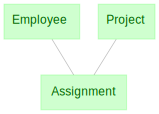

In [3]:
dj.Diagram(schema)

### Interpreting the Diagram

In this diagram, observe the following features:

* **Green boxes with underlined names**: These are the tables. The underline indicates these are independent entities (dimensions) with their own primary keys.
* **Thin solid lines**: Both edges use thin solid lines, indicating that the foreign keys from `Assignment` are part of its primary key.
* **Converging pattern**: The `Assignment` table has two foreign keys converging into it, which is the visual signature of an association table creating a many-to-many relationship.
* **Top-to-bottom layout**: Independent entities (`Employee` and `Project`) are at the top, and the dependent table (`Assignment`) is at the bottom.

**Interactive Features**: In Jupyter notebooks, you can hover over any table in the diagram to see its complete definition, including all attributes and constraints.


# Understanding Line Styles

The most important feature of DataJoint diagrams is how **line styles indicate relationship types**. There are three types of lines, each conveying specific information about how tables are related.

## The Three Line Styles

### 1. Thick Solid Line (━━━)

**Meaning**: One-to-one relationship where the foreign key constitutes the **entire primary key** of the child table.

**Conceptual Model**: The child entity is a **specialized extension or elaboration** of the parent entity. The child doesn't have its own independent identity—it IS the parent, just with additional information attached.

**Characteristics**:
- Child table shares the exact same primary key as the parent
- Creates the strongest form of dependency and unified identity
- Child inherits the parent's complete identity
- Perfect for adding optional or modular information to an entity
- Enables direct joins across multiple levels of hierarchy

**Example Use Cases**:
- Workflow sequences: Order → Shipment → Delivery (each step extends the order)
- Optional entity extensions: Customer → CustomerPreferences (preferences extend customer)
- Modular data splits: Experiment → ExperimentNotes (notes extend experiment)
- One-to-one specializations where child adds detail without changing identity

**Think of it as**: "Child extends parent" or "Child specializes parent"

### 2. Thin Solid Line (───)

**Meaning**: One-to-many relationship where the foreign key is **part of** (but not all of) the child's primary key.

**Conceptual Model**: The child entity **belongs to or is contained within** the parent entity. The child has its own identity, but only within the context of its parent. Multiple children can exist for each parent, each identified by the parent's key plus additional distinguishing attributes.

**Characteristics**:
- Child table has a composite primary key: parent's PK + additional field(s)
- Creates hierarchical ownership or containment structures
- Child's identity is contextualized by parent (e.g., "Account #3 of Customer #42")
- Parent's primary key "cascades" down, becoming part of child's identity
- Enables direct joins to ancestors without intermediate tables

**Example Use Cases**:
- Hierarchies: Study → Subject → Session → Scan (sessions belong to subjects)
- Ownership: Customer → Account (accounts belong to customers)
- Containment: Folder → File (files are contained in folders)
- Parts-of: Order → OrderItem (items are parts of orders)

**Think of it as**: "Child belongs to parent" or "Child is contained in parent"

### 3. Dashed Line (- - - -)

**Meaning**: One-to-many relationship where the foreign key is a **secondary attribute** (not part of the primary key).

**Conceptual Model**: The child entity **references or associates with** the parent but maintains complete independence. The child has its own identity that is unrelated to the parent, and the parent is just one of many attributes describing the child.

**Characteristics**:
- Child table has its own independent primary key
- Foreign key appears below the line (in secondary attributes)
- Relationship is "looser" - no identity cascade
- Cannot skip intermediate tables in joins
- Relationship can be more easily changed or made optional

**Example Use Cases**:
- Optional associations: Product → Manufacturer (product exists independently)
- References that might change: Employee → Department (employee might transfer)
- Loose couplings: Document → Author (document has independent identity)
- When child entity has independent identity from parent

**Think of it as**: "Child references parent" or "Child is loosely associated with parent"

## Summary: The Conceptual Framework

Understanding the semantic difference between line types:

| Line Type | Semantic Relationship | Identity | Cardinality |
|-----------|----------------------|----------|-------------|
| **Thick Solid** | Extension/Specialization | Shared | One-to-one |
| **Thin Solid** | Containment/Belonging | Contextualized | One-to-many |
| **Dashed** | Reference/Association | Independent | One-to-many |

**Key Insight**: Solid lines (thick or thin) indicate that the parent's identity becomes part of the child's identity, either completely (thick) or partially (thin). Dashed lines indicate the child maintains its own independent identity.

## Key Conceptual Distinction: Containment vs. Extension

The choice between thin and thick solid lines reflects a fundamental design decision about the **semantic relationship** between entities:

### Thin Lines → Containment/Belonging (One-to-Many)

When you use a thin solid line, you're saying:
- *"The child belongs to the parent"*
- *"Multiple children can exist within each parent"*
- *"The child's identity includes the parent's identity"*

**Example**: A `Session` belongs to a `Subject`. You can have Session 1, Session 2, Session 3 all belonging to the same subject. The sessions are identified as "Subject 42, Session 1" and "Subject 42, Session 2".

```
-> Subject
session : int
```

**Result**: Composite primary key `(subject_id, session)` → Thin solid line

### Thick Lines → Extension/Specialization (One-to-One)

When you use a thick solid line, you're saying:
- *"The child extends the parent with additional information"*
- *"There can be at most one child for each parent"*
- *"The child and parent share the same identity"*

**Example**: A `Shipment` extends an `Order`. Once an order is placed, it may or may not be shipped. If it's shipped, there's exactly one shipment record that shares the order's identity.

```
-> Order
```

**Result**: Primary key is just `order_id` (inherited) → Thick solid line

### Visual Summary

```
Parent Table
     │
     ├─── (thin solid) ──→  Child has: Parent PK + own fields → "belongs to"
     │
     └═══ (thick solid) ══→  Child has: Parent PK only → "extends"
```

### When to Choose Which

Ask yourself: "Can there be multiple children for each parent?"

- **Yes** → Use thin solid line (child belongs to parent)
- **No** → Use thick solid line (child extends parent)

## Concrete Examples: Containment vs. Extension

Let's illustrate the distinction with two concrete scenarios:

### Scenario 1: Experiment Sessions (Containment - Thin Line)

In a lab, an experiment has multiple sessions. Each session belongs to its experiment:

```python
class Experiment(dj.Manual):
    definition = """
    experiment_id : int
    ---
    experiment_name : varchar(100)
    """

class Session(dj.Manual):
    definition = """
    -> Experiment         # Part of primary key
    session : int         # Additional PK component
    ---
    session_date : date
    """
```

**Relationship**: Session **belongs to** Experiment
- Can have Session 1, Session 2, Session 3... all for the same experiment
- Session identity: "Experiment 5, Session 2"
- **Thin solid line** in diagram
- Think: "sessions are contained within experiments"

### Scenario 2: Experiment Notes (Extension - Thick Line)

Sometimes you want to add optional notes to an experiment without cluttering the main table:

```python
class Experiment(dj.Manual):
    definition = """
    experiment_id : int
    ---
    experiment_name : varchar(100)
    """

class ExperimentNotes(dj.Manual):
    definition = """
    -> Experiment         # This IS the primary key
    ---
    notes : varchar(4000)
    added_date : timestamp
    """
```

**Relationship**: ExperimentNotes **extends** Experiment
- Can have at most one notes entry per experiment
- Notes identity: same as experiment (shares `experiment_id`)
- **Thick solid line** in diagram
- Think: "notes are an optional extension of experiment"

### The Decision Tree

```
Do multiple children exist for each parent?
│
├─ YES ──→ Thin Solid Line (Containment/Belonging)
│          Child PK: parent_pk + own_field(s)
│          Example: One experiment has many sessions
│
└─ NO ───→ Thick Solid Line (Extension/Specialization)
           Child PK: parent_pk only
           Example: One experiment has zero or one notes entry
```

## Visual Examples of Each Line Style

Let's create schemas that demonstrate each type of line. We'll use variations of a simple customer-account relationship.


### Example 1: Dashed Line (Secondary Foreign Key)


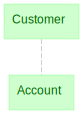

In [4]:
schema_dashed = dj.Schema('diagram_dashed')

@schema_dashed
class Customer(dj.Manual):
    definition = """
    customer_id : int
    ---
    name : varchar(50)
    """

@schema_dashed  
class Account(dj.Manual):
    definition = """
    account_number : int
    ---
    -> Customer
    balance : decimal(10,2)
    """

dj.Diagram(schema_dashed)


**Dashed line** from `Customer` to `Account`: The foreign key `customer_id` is in the secondary attributes of `Account` (below the `---` line). Each account has its own independent ID (`account_number`), and the relationship to customer is secondary. 

This represents a **reference or loose association** - the account maintains its own identity independent of the customer. This is a one-to-many relationship (one customer can have many accounts), and accounts could theoretically be reassigned to different customers by updating the foreign key (though in practice, we prefer delete-and-insert over updates).

### Example 2: Thin Solid Line (Composite Primary Key)


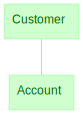

In [5]:
schema_thin = dj.Schema('diagram_thin')

@schema_thin
class Customer(dj.Manual):
    definition = """
    customer_id : int
    ---
    name : varchar(50)
    """

@schema_thin
class Account(dj.Manual):
    definition = """
    -> Customer
    account_number : int
    ---
    balance : decimal(10,2)
    """

dj.Diagram(schema_thin)


**Thin solid line** from `Customer` to `Account`: The foreign key `customer_id` is part of `Account`'s primary key (above the `---` line). The primary key of `Account` is the composite `(customer_id, account_number)`. 

This represents **containment or belonging** - each account belongs to and is identified within the context of its customer. Account #3 means nothing on its own; it's "Account #3 of Customer #42". This is a one-to-many relationship with identity cascade, creating a hierarchical structure where accounts are owned by customers.

### Example 3: Thick Solid Line (Primary Key is Foreign Key)


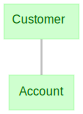

In [6]:
schema_thick = dj.Schema('diagram_thick')

@schema_thick
class Customer(dj.Manual):
    definition = """
    customer_id : int
    ---
    name : varchar(50)
    """

@schema_thick
class Account(dj.Manual):
    definition = """
    -> Customer
    ---
    balance : decimal(10,2)
    """

dj.Diagram(schema_thick)


**Thick solid line** from `Customer` to `Account`: The foreign key IS the entire primary key of `Account`. The primary key of `Account` is just `customer_id` (inherited from `Customer`). 

This represents an **extension or specialization** - the account extends the customer entity with additional financial information. Customer and account share the same identity; they are one-to-one. This is useful when you want to modularize data (separate customer info from account info) while maintaining that each customer can have at most one account. Note that `Account` is no longer underlined in the diagram, indicating it's not an independent dimension but rather an extension of `Customer`.

# What Diagrams Show and Don't Show

Understanding the limitations of diagram notation is just as important as understanding what they do show.

## What Diagrams Clearly Indicate

✅ **Line Style (Thick/Thin/Dashed)**:
- Whether foreign keys are in primary key or secondary attributes
- Whether relationships are one-to-one (thick) or one-to-many (thin/dashed)
- Whether primary keys cascade through relationships (solid lines)

✅ **Direction of Dependencies**:
- Which table depends on which (arrows point from parent to child)
- Workflow order (top to bottom)
- Which tables are independent vs. dependent

✅ **Table Types**:
- Underlined names = independent entities (dimensions)
- Non-underlined names = dependent entities (no independent identity)
- Color coding for table tiers (Manual, Lookup, Imported, Computed, etc.)

✅ **Association Patterns**:
- Converging lines indicate association tables
- Many-to-many relationships (two foreign keys in primary key)

## What Diagrams Don't Show

❌ **Nullable Foreign Keys**:
- Whether a foreign key is nullable (allows NULL values)
- Cannot distinguish between mandatory and optional relationships
- Must examine table definition to see nullable modifiers

❌ **Secondary Unique Constraints**:
- Unique indexes on secondary attributes
- Could convert a one-to-many into a one-to-one relationship
- Not visible in the diagram at all

❌ **Actual Attribute Names**:
- Only table names are shown (hover to see attributes)
- Foreign key field names might be renamed via projection
- Must inspect definition to see exact field names

❌ **Data Types and Constraints**:
- Cannot see CHECK constraints, default values, etc.
- Must examine table definition for these details

❌ **Composite Unique Constraints**:
- Complex uniqueness rules beyond the primary key
- May fundamentally change relationship semantics

## Best Practice

**Design Principle**: DataJoint users generally avoid secondary unique constraints when the primary key structure can enforce uniqueness. Making foreign keys part of the primary key (creating solid lines) provides two major benefits:

1. **Visual Clarity**: The relationship type is immediately obvious from the diagram
2. **Query Simplicity**: Primary keys cascade through foreign keys, enabling direct joins between distant tables


# Practical Tips for Working with Diagrams

## How to Read a Schema Quickly

When encountering a new schema diagram, follow this systematic approach:

1. **Identify Independent Entities** (top of diagram, underlined)
   - These are your starting points for data entry
   - No dependencies on other tables
   
2. **Trace the Solid Lines** (thick or thin)
   - Follow the cascading primary keys
   - Understand which tables can be joined directly
   
3. **Spot Association Tables** (converging patterns)
   - Look for tables with multiple foreign keys in their primary key
   - These represent many-to-many relationships
   
4. **Check Line Thickness**
   - Thick lines = one-to-one relationships (workflow steps, optional extensions)
   - Thin lines = one-to-many hierarchies (ownership, containment)
   - Dashed lines = one-to-many loose associations

## Designing with Diagrams in Mind

When designing a new schema, consider:

**Use Solid Lines When**:
- Building hierarchical structures (Study → Subject → Session)
- Creating workflow sequences (Order → Ship → Deliver)
- You want to enable direct joins across levels

**Use Dashed Lines When**:
- Child has independent identity from parent
- Relationship might change frequently
- You don't want primary key cascade

**Use Thick Lines When**:
- Creating one-to-one relationships
- Extending entities with optional information
- Modeling sequential workflows

## Diagram-Driven Queries

The diagram structure directly informs query patterns:

**Solid Line Paths** (direct joins possible):
```python
# If Study → Subject → Session are connected by solid lines:
Study * Session  # Valid join, no need to include Subject
```

**Dashed Line Paths** (must include intermediate tables):
```python
# If Study ---> Subject (dashed), Subject → Session (solid):
Study * Subject * Session  # Must include Subject
```

## Common Patterns at a Glance

| Pattern | Line Type | Primary Key Structure | Use Case |
|---------|-----------|----------------------|----------|
| Independent entities | None (top level) | Own PK | Starting points |
| Hierarchy | Thin solid | Parent PK + own field(s) | Containment, ownership |
| Sequence | Thick solid | Parent PK only | Workflows, one-to-one |
| Secondary reference | Dashed | Own PK | Association |
| Association table | Multiple thin solid | Multiple parent PKs | Many-to-many |

## Interactive Exploration

**In Jupyter Notebooks**:
- **Hover** over tables to see complete definitions (also works if you save the diagram as a SVG file)

**Filtering Diagrams**:
```python
# Show only specific tables
dj.Diagram(Table1) + dj.Diagram(Table2)

# Show table and its immediate dependencies
dj.Diagram(Table1) - 1

# Show table and its immediate up to seven layears up in the graph
dj.Diagram(Table1) - 7

# Show table and what depends on it  
dj.Diagram(Table1) + 1

# Show table and what depends on it up to seven layers down in the graph
dj.Diagram(Table1) + 7

# Show table and what depends on it up to seven layers down in the graph
dj.Diagram(Table1) + 7

```

## Summary

DataJoint diagrams are powerful tools for:
- **Understanding** existing schemas quickly
- **Communicating** design decisions visually
- **Planning** query strategies
- **Validating** relationship structures

The key is understanding that **line style encodes relationship semantics**: thick solid lines for one-to-one, thin solid lines for cascading one-to-many, and dashed lines for non-cascading one-to-many relationships. This visual language makes complex schemas comprehensible at a glance.
